##### - TODO moze jakas analiza tych akcji (Power text)??

In [1]:
import pandas as pd
from scripts.helper import *
import matplotlib.pyplot as plt

In [2]:
ptaki_df = pd.read_json('data/master.json')
names = ptaki_df["Common name"]
ptaki_df = ptaki_df.drop(["id","rulings","Expansion","additionalRulings", "Scientific name",  "Forest", "Flocking",
    "Grassland",
    "Wetland","Power text", "Note","Anatomist",
    "Cartographer",
    "Historian",
    "Photographer",
    "Backyard Birder",
    "Bird Bander",
    "Bird Counter",
    "Bird Feeder",
    "Diet Specialist",
    "Enclosure Builder",
    "Falconer",
    "Fishery Manager",
    "Food Web Expert",
    "Forester",
    "Large Bird Specialist",
    "Nest Box Builder",
    "Omnivore Expert",
    "Passerine Specialist",
    "Platform Builder",
    "Prairie Manager",
    "Rodentologist",
    "Viticulturalist",
    "Wetland Scientist",
    "Wildlife Gardener",
    "Caprimulgiform Specialist",
    "Small Clutch Specialist",
    "Endangered Species Protector",
    "Beak Pointing Left",
    "Beak Pointing Right"], axis =1)

In [3]:
ptaki_df["PowerCategory"] = ptaki_df["PowerCategory"].apply(lambda x: x if x not in {"Hunting and fishing", "Hunting and Fishing"} else "Hunting/Fishing")
ptaki_df["PowerCategory"] = ptaki_df["PowerCategory"].apply(lambda x: x if x != "Tucking" else "Flocking")
ptaki_df.groupby(["PowerCategory"]).size()

PowerCategory
Caching Food            12
Card-drawing            35
Egg-laying              35
Flocking                51
Food from Birdfeeder    12
Food from Supply        19
Food-related            48
Hunting/Fishing         40
Other                   74
dtype: int64

In [4]:
# check Other power cat
ptaki_df[["Common name","Wingspan"]].loc[ptaki_df["Wingspan"] == '*']

,Common name,Wingspan
152,Emu,*
243,Kākāpō,*
255,Little Penguin,*
279,North Island Brown Kiwi,*
377,Southern Cassowary,*


/home/julia/miniconda3/envs/sklearn_env/lib/python3.12/site-packages/seaborn/_core/plot.py:1491: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):


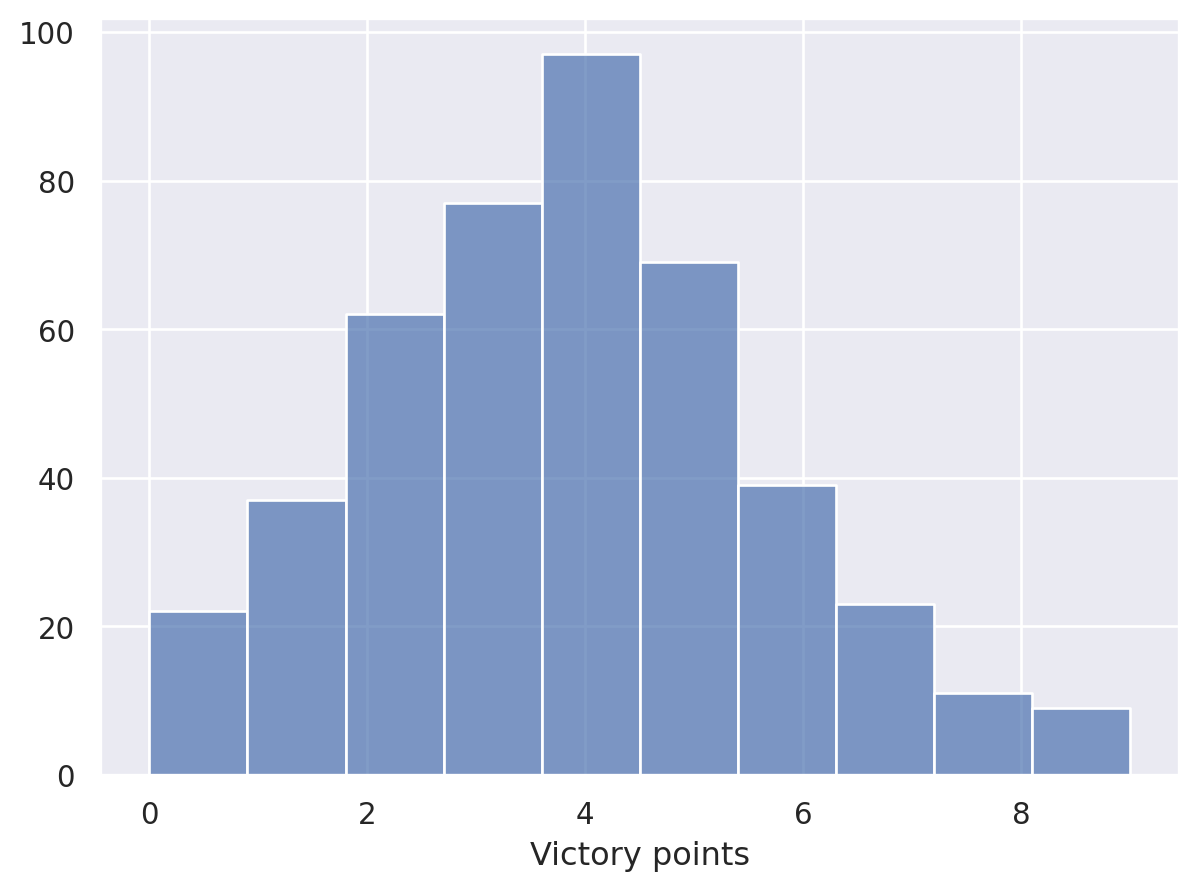

In [5]:
import seaborn.objects as so

ptaki_df["Victory points"] = ptaki_df["Victory points"].apply(lambda x: float(x))
p = so.Plot(ptaki_df, "Victory points")
p.add(so.Bars(), so.Hist(bins=10))

/home/julia/miniconda3/envs/sklearn_env/lib/python3.12/site-packages/seaborn/_core/plot.py:1491: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):


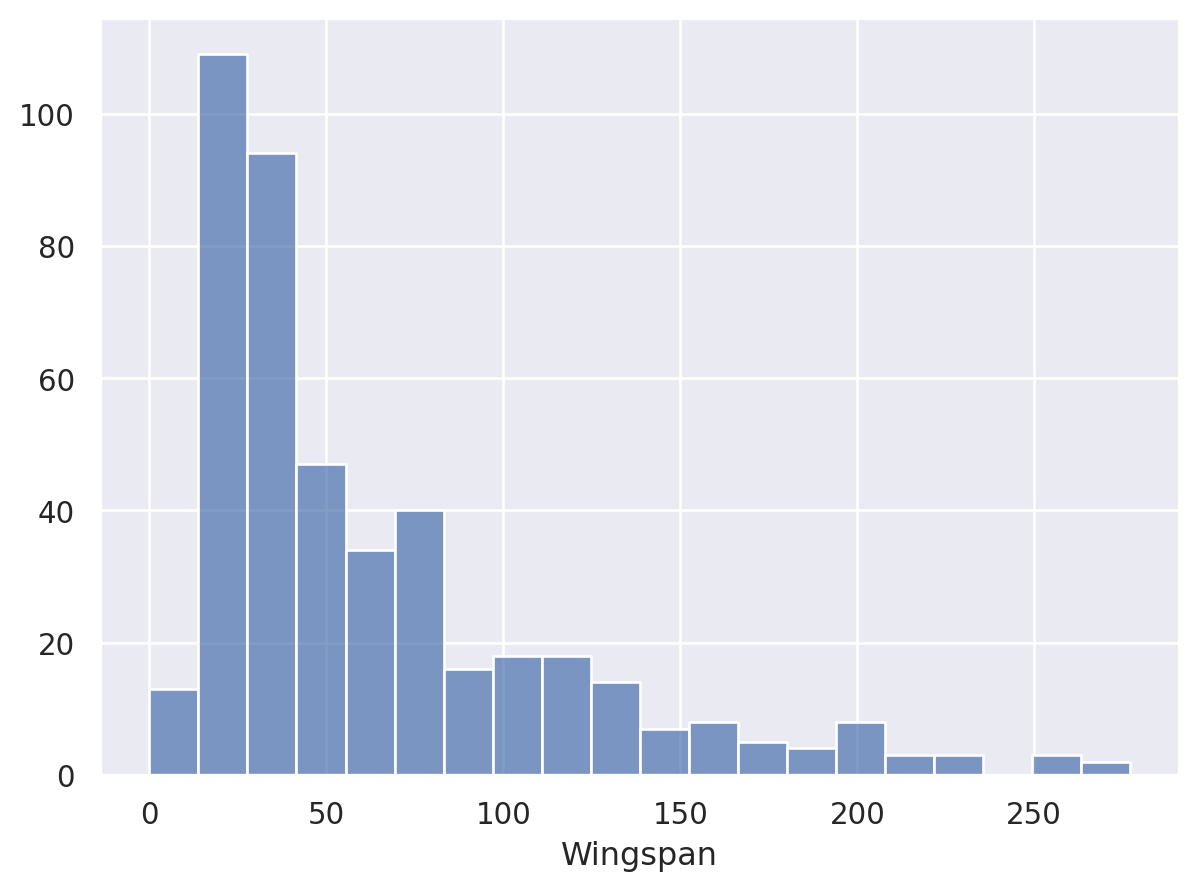

In [6]:
ptaki_df["Special Wingspan"] = ptaki_df["Wingspan"].apply(lambda x: 0 if x != "*" else 1)
ptaki_df["Wingspan"] = ptaki_df["Wingspan"].apply(lambda x: float(x) if x != "*" else 0) # na pewno dac 0 jak specjalne?
p = so.Plot(ptaki_df, "Wingspan")
p.add(so.Bars(), so.Hist(bins =20))

In [20]:
ptaki_df = ptaki_df.fillna(0)
cols = ['Predator','Bonus card','/ (food cost)', '* (food cost)']

for col in cols:
    ptaki_df[col]= ptaki_df[col].apply(lambda x: 1 if x != 0 else x)
    
for c in ["Color", "PowerCategory"]:
    ptaki_df[c]= ptaki_df[c].apply(lambda x: "None" if x == 0 else x)

In [21]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

column_trans = ColumnTransformer(
    [('norm_length', MinMaxScaler(), ['Wingspan']),
    ('one_hot_nest', OneHotEncoder(), ['Color','Nest type',  'PowerCategory'])],
    remainder='drop', verbose_feature_names_out=False)

column_trans.fit(ptaki_df)
column_trans.get_feature_names_out()

X_trans = column_trans.transform(ptaki_df.drop("Victory points", axis =1))

## Linear regression

In [22]:
from sklearn.model_selection import train_test_split
X = X_trans
y = ptaki_df["Victory points"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [23]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train)

reg.predict(X_test[1])

array([2.41661052])

In [24]:
test_predictions = reg.predict(X_test)

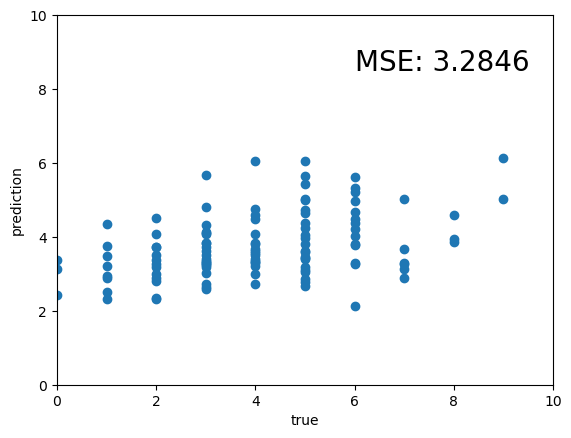

In [25]:
plot_regression(y_test,test_predictions,"LinRegMSE")

## SVM
### regression

In [26]:
from sklearn import svm
regr = svm.SVR()
regr.fit(X_train, y_train)

svm_pred = regr.predict(X_test)

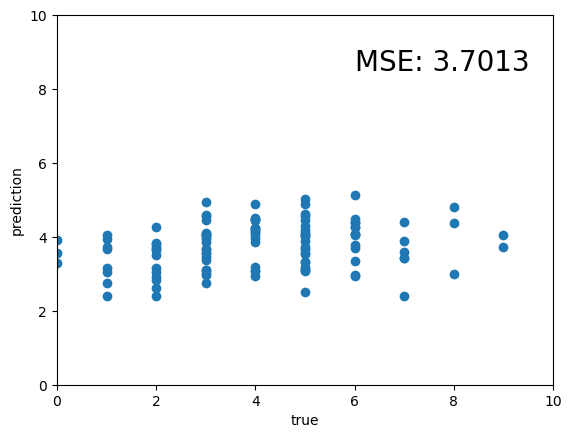

In [27]:
plot_regression(y_test,svm_pred,"SVM_MSE")

#### classification

In [28]:
classs = svm.SVC()
classs.fit(X_train, y_train)

svm_pred = classs.predict(X_test)

In [29]:
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(y_test, svm_pred)

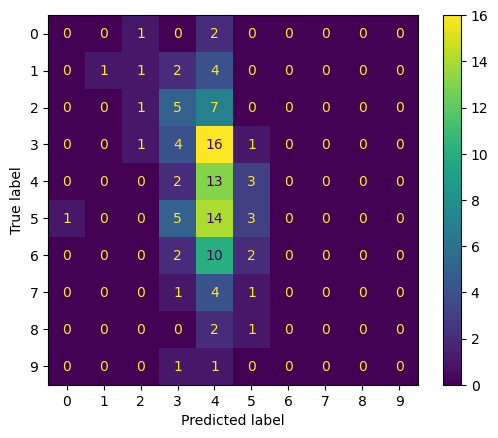

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf)
disp.plot()

In [33]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1.0)
logreg.fit(X_train, y_train)

lgr_pred = logreg.predict(X_test)

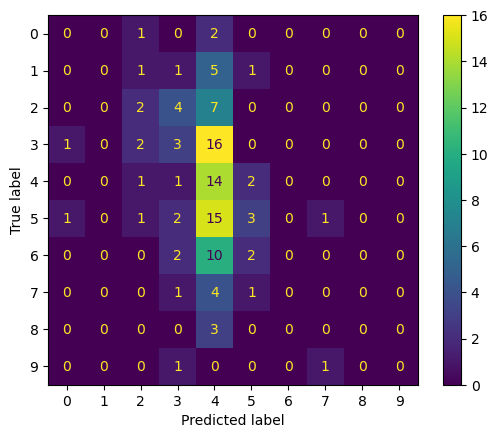

In [34]:
confl = confusion_matrix(y_test, lgr_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confl)
disp.plot()

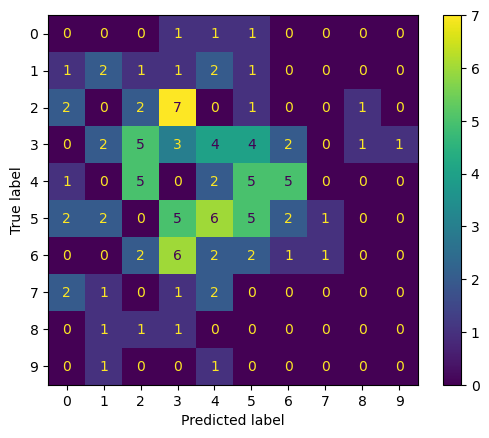

In [36]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

tree_pred = tree.predict(X_test)

conft = confusion_matrix(y_test, tree_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conft)
disp.plot()

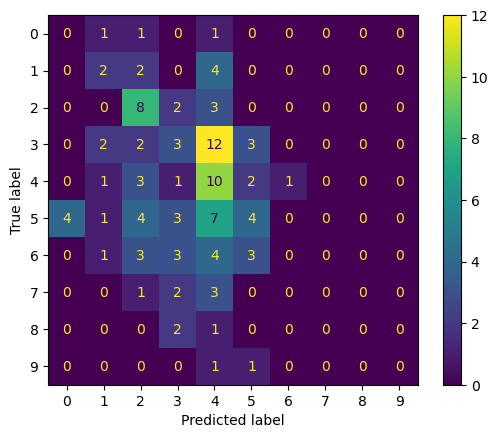

In [45]:
from sklearn.neighbors import KNeighborsClassifier

knn =  KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)

knn_pred = knn.predict(X_test)

confk = confusion_matrix(y_test, knn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confk)
disp.plot()